<a href="https://colab.research.google.com/github/Kryptera-K/AEP-ATR-DI-CCI-Kijun-Shield-Strategy/blob/main/AEP_D1_%5B'DI__Change_Direction_Downward'_'ATR_Rising'%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.9 MB/s eta 0:00:00


In [ ]:
Entry conditions: ['DI-_Change_Direction_Downward' 'ATR_Rising']
Exit conditions: ['CCI_Change_Down' 'Price_Cross_Kijun_Bearish']
Total Trades: 81
Total Return [%]: 1357.8137734584816, Benchmark Return [%]: 933.8440946895001
Conditions met: enough trades AND outperforms benchmark.

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Parameters
# -------------------------
symbol = "AEP"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# ATR Calculation
# -------------------------
ATR_period = 14

def calculate_atr(df, period=14):
    high_low = df['High'] - df['Low']
    high_close = abs(df['High'] - df['Close'].shift(1))
    low_close = abs(df['Low'] - df['Close'].shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(window=period, min_periods=1).mean()

df['ATR'] = calculate_atr(df, period=ATR_period)
df['ATR_Rising'] = df['ATR'] > df['ATR'].shift(1)

# -------------------------
# DI- Calculation
# -------------------------
di_period = 14

def calculate_di(df, period=di_period):
    df = df.copy()
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    df['TR_smooth'] = df['TR'].rolling(period).sum()
    df['+DM_smooth'] = df['+DM'].rolling(period).sum()
    df['-DM_smooth'] = df['-DM'].rolling(period).sum()

    df['DI+'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
    df['DI-'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])
    return df

df = calculate_di(df, period=di_period)

# DI- Change Direction Downward
di_shift_1 = 5
di_shift_2 = 10
df['DI-_Change_Direction_Downward'] = (df['DI-'].shift(di_shift_1) < df['DI-'].shift(di_shift_2)) & \
                                     (df['DI-'] < df['DI-'].shift(di_shift_1))

# -------------------------
# CCI Calculation
# -------------------------
cci_period = 14
cci_shift_1 = 5
cci_shift_2 = 10

def calculate_cci(df, period=cci_period):
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma = tp.rolling(period).mean()
    mean_dev = tp.rolling(period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    return (tp - sma) / (0.015 * mean_dev)

df['CCI'] = calculate_cci(df, period=cci_period)
df['CCI_Change_Down'] = (df['CCI'] < df['CCI'].shift(cci_shift_1)) & \
                        (df['CCI'].shift(cci_shift_1) >= df['CCI'].shift(cci_shift_2))

# -------------------------
# Ichimoku Kijun Bearish
# -------------------------
df['kijun_sen'] = (df['High'].rolling(26).max() + df['Low'].rolling(26).min()) / 2
df['Price_Cross_Kijun_Bearish'] = (df['Close'].shift(1) > df['kijun_sen'].shift(1)) & \
                                  (df['Close'] < df['kijun_sen'])

# -------------------------
# Entry / Exit Signals
# -------------------------
entry_conditions = ['DI-_Change_Direction_Downward', 'ATR_Rising']
exit_conditions  = ['CCI_Change_Down', 'Price_Cross_Kijun_Bearish']

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------
entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

print(pf.stats())
pf.plot().show()


/tmp/ipython-input-1100395184.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


Start                                2000-01-03 00:00:00
End                                  2025-09-26 00:00:00
Period                                6473 days 00:00:00
Start Value                                     100000.0
End Value                                 1438187.802629
Total Return [%]                             1338.187803
Benchmark Return [%]                          933.844478
Max Gross Exposure [%]                             100.0
Total Fees Paid                             75178.429219
Max Drawdown [%]                               61.091309
Max Drawdown Duration                 1034 days 00:00:00
Total Trades                                          81
Total Closed Trades                                   81
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   65.432099
Best Trade [%]                                 71.848672
Worst Trade [%]                

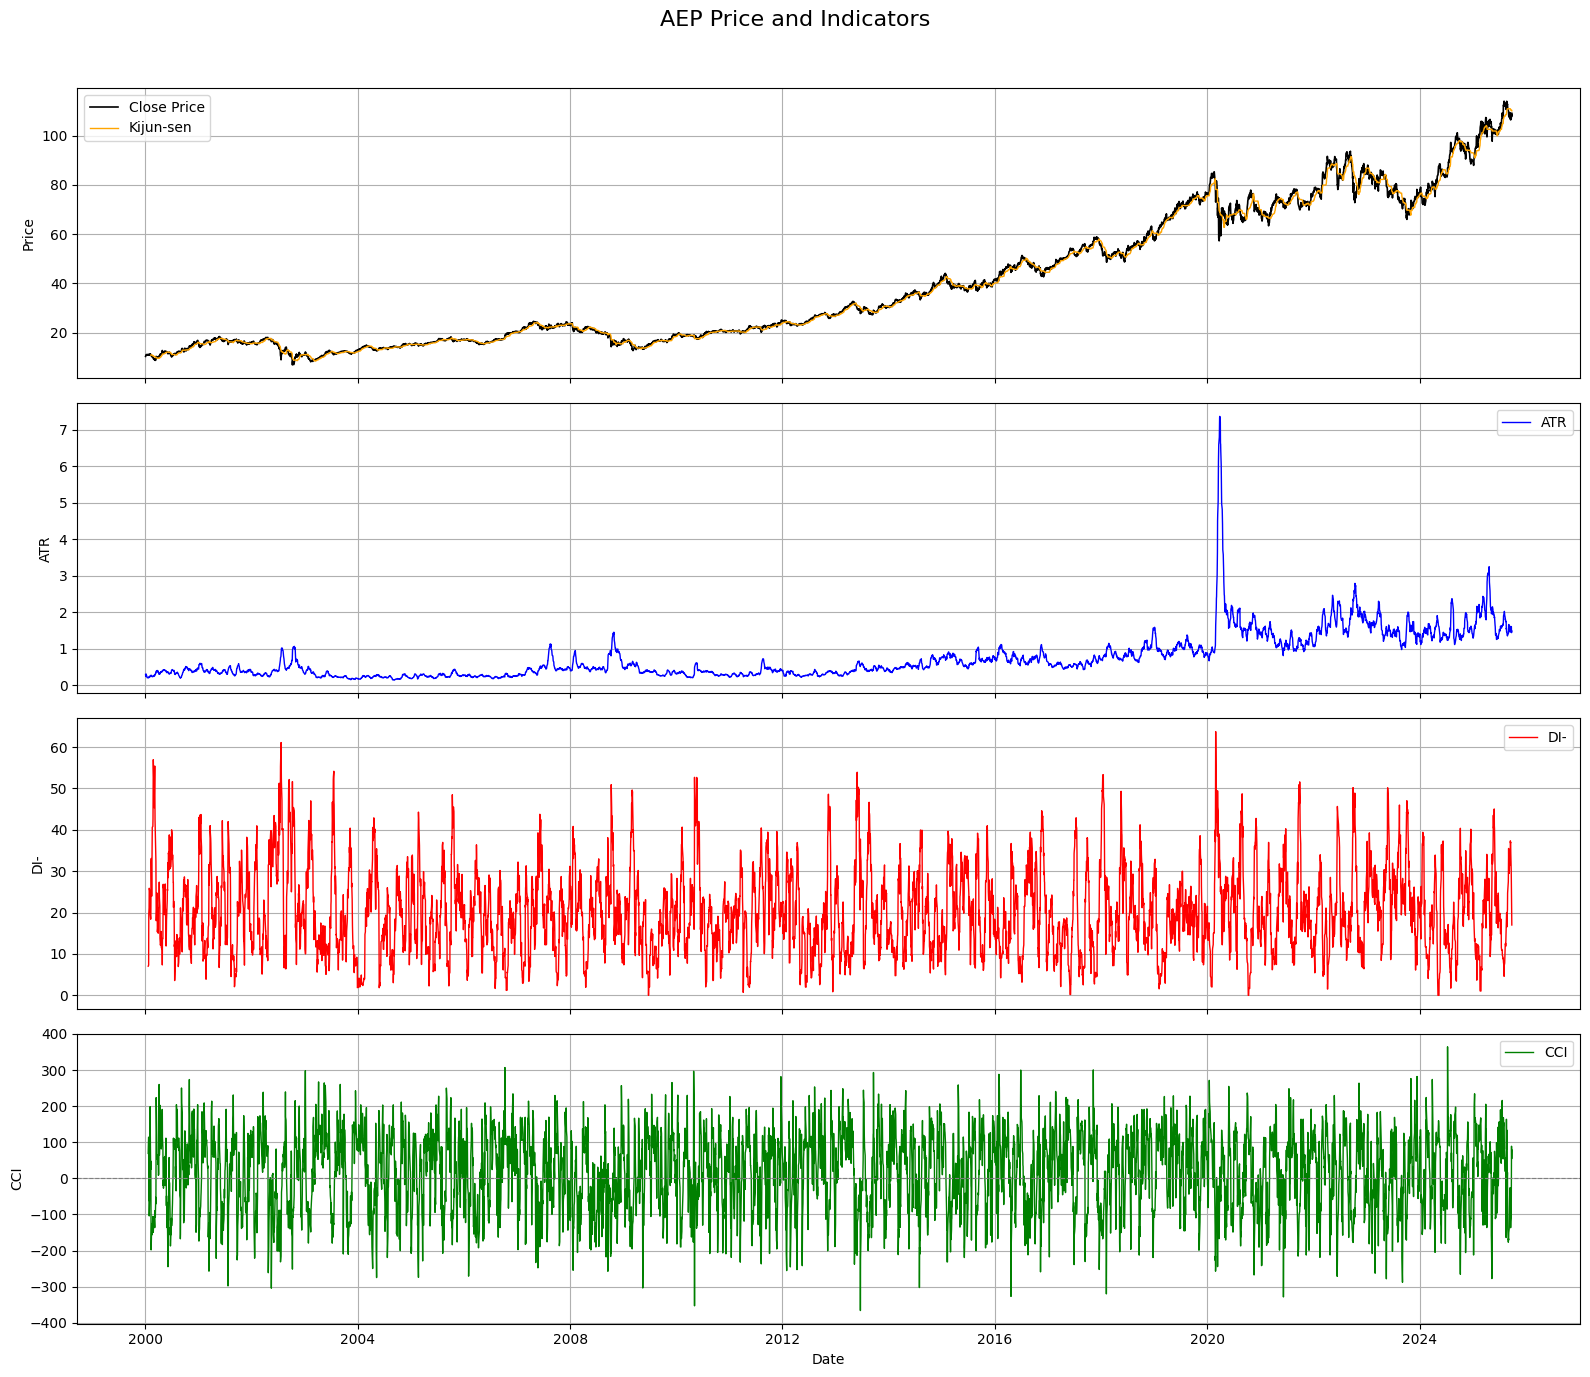

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# Figure setup
# -------------------------
fig, axes = plt.subplots(4, 1, figsize=(16, 14), sharex=True)
fig.suptitle(f"{symbol} Price and Indicators", fontsize=16)

# -------------------------
# Panel 1: Price
# -------------------------
axes[0].plot(df['Close'], label='Close Price', color='black', linewidth=1.2)
axes[0].plot(df['kijun_sen'], label='Kijun-sen', color='orange', linewidth=1)
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True)

# -------------------------
# Panel 2: ATR
# -------------------------
axes[1].plot(df['ATR'], label='ATR', color='blue', linewidth=1)
axes[1].set_ylabel('ATR')
axes[1].legend()
axes[1].grid(True)

# -------------------------
# Panel 3: DI-
# -------------------------
axes[2].plot(df['DI-'], label='DI-', color='red', linewidth=1)
axes[2].set_ylabel('DI-')
axes[2].legend()
axes[2].grid(True)

# -------------------------
# Panel 4: CCI
# -------------------------
axes[3].plot(df['CCI'], label='CCI', color='green', linewidth=1)
axes[3].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axes[3].set_ylabel('CCI')
axes[3].legend()
axes[3].grid(True)

# -------------------------
# X-axis label
# -------------------------
axes[3].set_xlabel('Date')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-09-26 00:00:00
Period                         6473 days 00:00:00
Start Value                              100000.0
End Value                          1033844.477658
Total Return [%]                       933.844478
Benchmark Return [%]                   933.844478
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        62.085833
Max Drawdown Duration          1177 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      933844.477658
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Parameters
# -------------------------
symbol = "AEP"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

cci_shift = 5
cci_shift_2 = 10
woodie_shift = 5

def calculate_cci(df, period=14):
    df = df.copy()
    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    # SMA of TP
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    # Mean Deviation
    df['MeanDev'] = df['TP'].rolling(period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    # CCI
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df

# -------------------------
# Generic CCI Signals
# -------------------------
def cci_zero_line_break_up(df):
    df['CCI_main'] = calculate_cci(df, 14)['CCI']
    return (df['CCI_main'] > 0) & (df['CCI_main'].shift(1) <= 0)

def cci_zero_line_break_down(df):
    df['CCI_main'] = calculate_cci(df, 14)['CCI']
    return (df['CCI_main'] < 0) & (df['CCI_main'].shift(1) >= 0)

def cci_change_up(df, shifts=cci_shift, shift_2 = cci_shift_2):
    df['CCI_main'] = calculate_cci(df, 14)['CCI']
    return (df['CCI_main'] > df['CCI_main'].shift(shifts)) & (df['CCI_main'].shift(shifts) <= df['CCI_main'].shift(shift_2))

def cci_change_down(df, shifts=cci_shift, shift_2 = cci_shift_2):
    df['CCI_main'] = calculate_cci(df, 14)['CCI']
    return (df['CCI_main'] < df['CCI_main'].shift(shifts)) & (df['CCI_main'].shift(shifts) >= df['CCI_main'].shift(shift_2))

def cci_cross_above(df, level):
    df['CCI_main'] = calculate_cci(df, 14)['CCI']
    return (df['CCI_main'] > level) & (df['CCI_main'].shift(1) <= level)

def cci_cross_below(df, level):
    df['CCI_main'] = calculate_cci(df, 14)['CCI']
    return (df['CCI_main'] < level) & (df['CCI_main'].shift(1) >= level)

def cci_rising(df, shifts=cci_shift):
    df['CCI_main'] = calculate_cci(df, 14)['CCI']
    return df['CCI_main'] > df['CCI_main'].shift(shifts)

def cci_falling(df, shifts=cci_shift):
    df['CCI_main'] = calculate_cci(df, 14)['CCI']
    return df['CCI_main'] < df['CCI_main'].shift(shifts)

def cci_higher_than(df, level):
    df['CCI_main'] = calculate_cci(df, 14)['CCI']
    return df['CCI_main'] > level

def cci_lower_than(df, level):
    df['CCI_main'] = calculate_cci(df, 14)['CCI']
    return df['CCI_main'] < level

df['CCI_Zero_Line_Break_Up'] = cci_zero_line_break_up(df)
df['CCI_Zero_Line_Break_Down'] = cci_zero_line_break_down(df)
df['CCI_Change_Up'] = cci_change_up(df, shifts=cci_shift, shift_2 = cci_shift_2)
df['CCI_Change_Down'] = cci_change_down(df, shifts=cci_shift, shift_2 = cci_shift_2)
df['CCI_Cross_Above_Level'] = cci_cross_above(df, level=0)
df['CCI_Cross_Below_Level'] = cci_cross_below(df, level=0)
df['CCI_Rising'] = cci_rising(df, shifts=cci_shift)
df['CCI_Falling'] = cci_falling(df, shifts=cci_shift)
df['CCI_Higher_Than_Level'] = cci_higher_than(df, level=0)
df['CCI_Lower_Than_Level'] = cci_lower_than(df, level=0)

# -------------------------
# Ichimoku Calculation
# -------------------------
# Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2
df['tenkan_sen'] = (df['High'].rolling(9).max() + df['Low'].rolling(9).min()) / 2

# Kijun-sen (Base Line): (26-period high + 26-period low)/2
df['kijun_sen'] = (df['High'].rolling(26).max() + df['Low'].rolling(26).min()) / 2

# Senkou Span A (Leading Span A): (Tenkan-sen + Kijun-sen)/2 shifted forward 26
df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)

# Senkou Span B (Leading Span B): (52-period high + 52-period low)/2 shifted forward 26
df['senkou_span_b'] = ((df['High'].rolling(52).max() + df['Low'].rolling(52).min()) / 2).shift(26)

# Chikou Span (Lagging Span): Close shifted -26
df['chikou_span'] = df['Close'].shift(-26)

# -------------------------
# Ichimoku Signals (True/False)
# -------------------------
# 1. Kumo Breakout Bearish
df['Kumo_Breakout_Bearish'] = (df['Close'] < df[['senkou_span_a','senkou_span_b']].min(axis=1))

# 2. Kumo Breakout Bullish
df['Kumo_Breakout_Bullish'] = (df['Close'] > df[['senkou_span_a','senkou_span_b']].max(axis=1))

# 3. Price Cross Kijunsen Bearish
df['Price_Cross_Kijun_Bearish'] = (df['Close'].shift(1) > df['kijun_sen'].shift(1)) & (df['Close'] < df['kijun_sen'])

# 4. Price Cross Kijunsen Bullish
df['Price_Cross_Kijun_Bullish'] = (df['Close'].shift(1) < df['kijun_sen'].shift(1)) & (df['Close'] > df['kijun_sen'])

# 5. Senkou Span Cross Bearish (A crosses below B)
df['Senkou_Span_Cross_Bearish'] = (df['senkou_span_a'].shift(1) > df['senkou_span_b'].shift(1)) & (df['senkou_span_a'] < df['senkou_span_b'])

# 6. Senkou Span Cross Bullish (A crosses above B)
df['Senkou_Span_Cross_Bullish'] = (df['senkou_span_a'].shift(1) < df['senkou_span_b'].shift(1)) & (df['senkou_span_a'] > df['senkou_span_b'])

# 7. TenkanSen Cross KijunSen Bearish
df['Tenkan_Kijun_Cross_Bearish'] = (df['tenkan_sen'].shift(1) > df['kijun_sen'].shift(1)) & (df['tenkan_sen'] < df['kijun_sen'])

# 8. TenkanSen Cross KijunSen Bullish
df['Tenkan_Kijun_Cross_Bullish'] = (df['tenkan_sen'].shift(1) < df['kijun_sen'].shift(1)) & (df['tenkan_sen'] > df['kijun_sen'])

di_shift = 5
di_shift_2 = 10

# -------------------------
# Calculate DI+ and DI-
# -------------------------
def calculate_di(df, period=14):
    df = df.copy()

    # True Range
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    # +DM and -DM
    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    # Wilder’s smoothing
    df['TR_smooth'] = df['TR'].rolling(period).sum()
    df['+DM_smooth'] = df['+DM'].rolling(period).sum()
    df['-DM_smooth'] = df['-DM'].rolling(period).sum()

    # DI+ and DI-
    df['DI+'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
    df['DI-'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])

    return df

df = calculate_di(df, period=14)

# -------------------------
# Functions 1–12
# -------------------------

# 1. DI- Change Direction Downward
def di_minus_change_direction_downward(df, shifts_1=di_shift, shifts_2=di_shift_2):
    return (df['DI-'].shift(shifts_1) < df['DI-'].shift(shifts_2)) & (df['DI-'] < df['DI-'].shift(shifts_1))

# 2. DI- Change Direction Upward
def di_minus_change_direction_upward(df, shifts_1=di_shift, shifts_2=di_shift_2):
    return (df['DI-'].shift(shifts_1) > df['DI-'].shift(shifts_2)) & (df['DI-'] > df['DI-'].shift(shifts_1))

# 3. DI- Is Falling
def di_minus_is_falling(df,shifts=di_shift):
    return df['DI-'] < df['DI-'].shift(shifts)

# 4. DI- Is Rising
def di_minus_is_rising(df,shifts=di_shift):
    return df['DI-'] > df['DI-'].shift(shifts)

# 5. DI+ Change Direction Downward
def di_plus_change_direction_downward(df, shifts_1=di_shift, shifts_2=di_shift_2):
    return (df['DI+'].shift(shifts_1) < df['DI+'].shift(shifts_2)) & (df['DI+'] < df['DI+'].shift(shifts_1))

# 6. DI+ Change Direction Upward
def di_plus_change_direction_upward(df, shifts_1=di_shift, shifts_2=di_shift_2):
    return (df['DI+'].shift(shifts_1) > df['DI+'].shift(shifts_2)) & (df['DI+'] > df['DI+'].shift(shifts_1))

# 7. DI+ Is Falling
def di_plus_is_falling(df, shifts=di_shift):
    return df['DI+'] < df['DI+'].shift(di_shift)

# 8. DI+ Is Rising
def di_plus_is_rising(df, shifts=di_shift):
    return df['DI+'] > df['DI+'].shift(di_shift)

# 9. DI+ Cross Above DI-
def di_plus_cross_above_minus(df):
    return (df['DI+'].shift(1) <= df['DI-'].shift(1)) & (df['DI+'] > df['DI-'])

# 10. DI+ Cross Below DI-
def di_plus_cross_below_minus(df):
    return (df['DI+'].shift(1) >= df['DI-'].shift(1)) & (df['DI+'] < df['DI-'])

# 11. DI+ Is Higher Than DI-
def di_plus_higher_than_minus(df):
    return df['DI+'] > df['DI-']

# 12. DI+ Is Lower Than DI-
def di_plus_lower_than_minus(df):
    return df['DI+'] < df['DI-']

df['DI-_Change_Direction_Downward'] = di_minus_change_direction_downward(df)
df['DI-_Change_Direction_Upward']   = di_minus_change_direction_upward(df)
df['DI-_Is_Falling'] = di_minus_is_falling(df)
df['DI-_Is_Rising']  = di_minus_is_rising(df)
df['DI+_Change_Direction_Downward'] = di_plus_change_direction_downward(df)
df['DI+_Change_Direction_Upward']   = di_plus_change_direction_upward(df)
df['DI+_Is_Falling'] = di_plus_is_falling(df)
df['DI+_Is_Rising']  = di_plus_is_rising(df)
df['DI+_Cross_Above_DI-'] = di_plus_cross_above_minus(df)
df['DI+_Cross_Below_DI-'] = di_plus_cross_below_minus(df)
df['DI+_Higher_Than_DI-'] = di_plus_higher_than_minus(df)
df['DI+_Lower_Than_DI-']  = di_plus_lower_than_minus(df)

# -------------------------
# Parameters
# -------------------------
ATR_period = 14
level = 2.0  # example level

# -------------------------
# ATR Function
# -------------------------
def calculate_atr(df, period=14):
    """
    Calculate ATR (Average True Range)
    df : pandas DataFrame with columns ['High', 'Low', 'Close']
    period : ATR period (default 14)
    """
    high_low = df['High'] - df['Low']
    high_close = abs(df['High'] - df['Close'].shift(1))
    low_close = abs(df['Low'] - df['Close'].shift(1))

    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()

    return atr

# -------------------------
# ATR Condition Functions
# -------------------------
def atr_change_up(df, atr_col='ATR'):
    return df[atr_col] > df[atr_col].shift(1)

def atr_change_down(df, atr_col='ATR'):
    return df[atr_col] < df[atr_col].shift(1)

def atr_cross_above(df, level, atr_col='ATR'):
    return (df[atr_col].shift(1) < level) & (df[atr_col] >= level)

def atr_cross_below(df, level, atr_col='ATR'):
    return (df[atr_col].shift(1) > level) & (df[atr_col] <= level)

def atr_is_falling(df, atr_col='ATR'):
    return df[atr_col] < df[atr_col].shift(1)

def atr_is_rising(df, atr_col='ATR'):
    return df[atr_col] > df[atr_col].shift(1)

def atr_higher_than(df, level, atr_col='ATR'):
    return df[atr_col] > level

def atr_lower_than(df, level, atr_col='ATR'):
    return df[atr_col] < level

# -------------------------
# Apply ATR Function
# -------------------------
df['ATR'] = calculate_atr(df, period=ATR_period)

# -------------------------
# Apply ATR Condition Functions
# -------------------------
df['ATR_Upward'] = atr_change_up(df)
df['ATR_Downward'] = atr_change_down(df)
df['ATR_Cross_Above_Level'] = atr_cross_above(df, level)
df['ATR_Cross_Below_Level'] = atr_cross_below(df, level)
df['ATR_Falling'] = atr_is_falling(df)
df['ATR_Rising'] = atr_is_rising(df)
df['ATR_Higher_Than_Level'] = atr_higher_than(df, level)
df['ATR_Lower_Than_Level'] = atr_lower_than(df, level)

# =========================================================
# Entry / Exit Signals
# =========================================================
entry_conditions = ['DI-_Change_Direction_Downward', 'ATR_Rising']
exit_conditions  = ['CCI_Change_Down', 'Price_Cross_Kijun_Bearish']

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# =========================================================
# Backtest
# =========================================================
entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

print(pf.stats())
pf.plot().show()

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Parameters
# -------------------------
symbol = "AEP"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# 1. Volume Rising
# -------------------------
shift_volume_para = 10
df['Volume_Rising'] = df['Volume'] > df['Volume'].shift(shift_volume_para)

# -------------------------
# 2. CCI
# -------------------------
cci_shift = 5
def calculate_cci(df, period=14):
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    SMA_TP = TP.rolling(period).mean()
    MeanDev = TP.rolling(period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    return (TP - SMA_TP) / (0.015 * MeanDev)

df['CCI'] = calculate_cci(df)
df['CCI_Lower_Than_Level'] = df['CCI'] < 0
df['CCI_Rising'] = df['CCI'] > df['CCI'].shift(cci_shift)

# -------------------------
# 3. Aroon Down Rises From Bottom
# -------------------------
aroon_period = 14
def aroon_down_rises(df, period=aroon_period):
    aroon_down = []
    for i in range(len(df)):
        if i < period:
            aroon_down.append(np.nan)
        else:
            low_period = df['Low'].iloc[i-period+1:i+1]
            days_since_low = period - 1 - low_period[::-1].values.argmin()
            aroon_down.append((period - days_since_low) / period * 100)
    df['Aroon_Down'] = aroon_down
    return (df['Aroon_Down'].shift(1) < 30) & (df['Aroon_Down'] > df['Aroon_Down'].shift(1))

df['Aroon_Down_Rises_From_Bottom'] = aroon_down_rises(df)

# -------------------------
# 4. DI- Change Direction Upward (ADX related)
# -------------------------
ADX_period = 14
# DI- calculation simplified
df['H-L'] = df['High'] - df['Low']
df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                     np.maximum(df['Low'].shift(1) - df['Low'],0), 0)
df['-DM_smooth'] = df['-DM'].rolling(ADX_period).sum()
df['TR_smooth'] = df['TR'].rolling(ADX_period).sum()
df['DI-'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])
di_shift = 5
di_shift_2 = 10
df['DI-_Change_Direction_Upward'] = (df['DI-'].shift(di_shift) > df['DI-'].shift(di_shift_2)) & (df['DI-'] > df['DI-'].shift(di_shift))

# -------------------------
# 5. Bears Power Downward
# -------------------------
ema_period = 13
df['EMA'] = df['Close'].ewm(span=ema_period, adjust=False).mean()
df['Bears_Power'] = df['Low'] - df['EMA']
df['BearP_Downward'] = df['Bears_Power'] < df['Bears_Power'].shift(1)

# -------------------------
# Combine Signals
# -------------------------
df['entry_signal'] = df['Volume_Rising'] & df['CCI_Lower_Than_Level'] & df['CCI_Rising']
df['exit_signal'] = df['Aroon_Down_Rises_From_Bottom'] & df['DI-_Change_Direction_Upward'] & df['BearP_Downward']

# -------------------------
# Backtest with vectorbt
# -------------------------
shifted_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

print(pf.stats())
pf.plot().show()


/tmp/ipython-input-1790573713.py:17: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Start                                2000-01-03 00:00:00
End                                  2025-09-25 00:00:00
Period                                6472 days 00:00:00
Start Value                                     100000.0
End Value                                 1043732.048818
Total Return [%]                              943.732049
Benchmark Return [%]                          943.002628
Max Gross Exposure [%]                             100.0
Total Fees Paid                             42563.441361
Max Drawdown [%]                               55.888386
Max Drawdown Duration                 1137 days 00:00:00
Total Trades                                          63
Total Closed Trades                                   62
Total Open Trades                                      1
Open Trade PnL                             -34731.662345
Win Rate [%]                                   59.677419
Best Trade [%]                                 31.417783
Worst Trade [%]                